# Homework 1: Image Formation and Sensing

## Color image demosaicing

Recall that in digital cameras the red, blue, and green sensors are interlaced in a Bayer pattern. Your goal is to fill the missing values in each channel to obtain a full color image. For this homework, you will implement three different interpolation algorithms. The input to the algorithm is a single image *im*, an N x M array of numbers between 0.0 and 1.0. These are measurements in the format shown in Figure 2, i.e. the top left pixel *im(0, 0)* is red, *im(0, 1)* is green, *im(1, 0)* is also green and *im(1, 1)* refers to the blue channel. Your goal is to create a single color image from these measurements.

<img src="mosaic.png">

In [1]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt

images = ['balloons.jpg', 'candy.jpg', 'cat.jpg', 'ip.jpg', 
          'puppy.jpg', 'squirrel.jpg', 'tree.jpg']

def show_image(img):
    plt.imshow(img, interpolation='nearest')
    

In [2]:
'''This array contains the mosaiced images which have to be demosaiced.'''
mosaiced_images = []
gtruth_images = []

'''A function to generate the mosaiced images from the given RGB images.'''
def generate_mosaic(image):
    mosaic = image[:, :, 1].copy() # green
    mosaic[::2, ::2] = image[::2, ::2, 0] # red
    mosaic[1::2, 1::2] = image[1::2, 1::2, 2] # blue
    return mosaic
        
'''A function to generate the mosaiced images for all the input images.'''
def generate_input(mosaiced_images, gtruth_images):
    for file in images:
        image = imread('input/' + file)
        image = image / 255.0
        gtruth_images.append(image)
        mosaiced_images.append(generate_mosaic(image))
        
generate_input(mosaiced_images, gtruth_images)

## Visualize the Images

To gain intuition, let's visualize the image encoded in the Bayer pattern. Run the code below to see both the mosaic image and the original image. In this problem, you will take the image encoded in a Bayer pattern and recover the full color image.

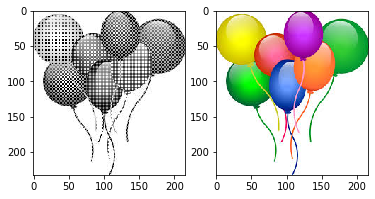

In [3]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(mosaiced_images[0], cmap='gray')
axarr[1].imshow(gtruth_images[0], cmap='gray')

## Implement your code here

There are several algorithms that we can use to recover the original image. You will implement three of them:

1) Implement the **nearest neighbour** (12 pt) algorithm

2) Implement the **linear interpolation** (12 pt) algorithm.

3) Then, implement a more advanced method such as the **adaptive gradient-based** (15 pt) algorithm, and compare the results.

These methods will be evaluated in the next section.

In [4]:
'''Methods to demosaic the image; the input is a mosaiced image and the output should be a
demosaiced image with R, G and B channels. The dimensions of the images should be the
same.'''

def demosaic_nn(im):
    '''
    Implement your nearest neighbour code here.
    '''
    result_nn = np.zeros((im.shape[0], im.shape[1], 3))
    
    temp_image = np.zeros((im.shape[0],im.shape[1]))
    #G channel image
    #select the nearest left pixels of 
    #and if the nearest left pixel not exist, then choose the neartest right Green pixel  
    g_image = im.copy()
    #interpolation on R pixels
    #avoid the demention unmatchable
    g_image[::2,2::2] = im[::2,1:im.shape[1]-1:2] 
    
    #the leftest side of R pixels: choose the right nearest pixels
    temp_image[::2,0] = temp_image[::2,1]
    #interpolatio on B pixels
    g_image[1::2,1::2] = im[1::2,0:im.shape[1]-1:2]
    
    
    # R channel image
    r_image = im.copy()
    #interpolation of G pixels
    #same row : choose the left nearest r pixels
    r_image[::2,1::2] = im[::2,0:im.shape[1]-1:2]
    #same column: choose the top nearest r pixels
    r_image[1::2,0::2] = im[0:im.shape[0]-1:2,0::2]
    
    #interpolation of B pixels
    #choose the left nearst R pixels that originally are G pixels position 
    r_image[1::2,1::2] = r_image[1::2,0:im.shape[1]-1:2]
    
    
    # B channel image
    b_image = im.copy()
    #interpolation of G pixels
    #same row: choose the left nearest B pixels value
    b_image[1::2,2::2] = im[1::2,1:im.shape[1]-1:2]
    #the leftest G pixel: choose the right nearest B pixel
    b_image[1::2,0] = im[1::2,1]
    # same column
    b_image[2::2,1::2] = im[1:im.shape[0]-1:2,1::2]
    #the rightest B pixel: choose the below nearest B pixel
    b_image[0,1::2] = im[1,1::2]
    
    #interpolation of R pixels
    #choose the left nearst pixels that originally are G pixels position
    b_image[::2,2::2] = b_image[::2,1:im.shape[1]-1:2]
    #the leftest R pixel: choose the right nearest pixels that originally are G pixels position
    b_image[::2,0] = b_image[::2,1]
        
    final_image_nn = [
        r_image,
        g_image,
        b_image
    ]
    return np.stack(final_image_nn,axis=-1)

In [5]:
def demosaic_interpolate(im):
    '''
    Implement your linear interpolation code here.
    '''
    # averge value of your neighbours
    # missing neighbour: mirror padding: reflect padding based on edges
    pad_size = 1
    image_padding = np.pad(im,pad_size,'reflect')
    
    # G channel image
    # the interpolation of R pixels
    g_image_linear = im.copy()
    g_temp_padding = image_padding.copy()
    for x in range(1,g_temp_padding.shape[0]-pad_size,2):
        for y in range(1,g_temp_padding.shape[1]-pad_size,2):
            g_temp_padding[x,y] = g_temp_padding[x,y-1] + g_temp_padding[x,y+1] + g_temp_padding[x-1,y] + g_temp_padding[x+1,y]
            g_temp_padding[x,y] = g_temp_padding[x,y] / 4.0
    # the interpolation of B pixels
    for x in range(2,g_temp_padding.shape[0]-pad_size,2):
        for y in range(2,g_temp_padding.shape[1]-pad_size,2):
            g_temp_padding[x,y] = g_temp_padding[x,y-1] + g_temp_padding[x,y+1] + g_temp_padding[x-1,y] + g_temp_padding[x+1,y]
            g_temp_padding[x,y] = g_temp_padding[x,y] / 4.0
    # crop the padding G image
    g_image_linear = g_temp_padding[pad_size:g_temp_padding.shape[0]-pad_size,pad_size:g_temp_padding.shape[1]-pad_size]
    
    # R channel image
    r_image_linear = im.copy()
    r_temp_padding = image_padding.copy()
    # the interpolation of G pixels
    #same row: average value of left nearest and right nearest: horizontal direction
    for x in range(1,r_temp_padding.shape[0]-pad_size,2):
        for y in range(2,r_temp_padding.shape[1]-pad_size,2):
            r_temp_padding[x,y] = ( r_temp_padding[x,y-1] + r_temp_padding[x,y+1] ) / 2.0  
    #same column: average value of top nearest and below nearest: vertical direction
    for x in range(2,r_temp_padding.shape[0]-pad_size,2):
        for y in range(1,r_temp_padding.shape[1]-pad_size,2):
            r_temp_padding[x,y] = ( r_temp_padding[x-1,y] + r_temp_padding[x+1,y] ) / 2.0  

    # the interpolation of B pixels
    # based on the interpolated G pixels
    for x in range(2,r_temp_padding.shape[0]-pad_size,2):
        for y in range(2,r_temp_padding.shape[1]-pad_size,2):
            r_temp_padding[x,y] = r_temp_padding[x,y-1] + r_temp_padding[x,y+1] + r_temp_padding[x-1,y] + r_temp_padding[x+1,y]
            r_temp_padding[x,y] = r_temp_padding[x,y] / 4.0
    
    #crop the padding R image
    r_image_linear = r_temp_padding[pad_size:r_temp_padding.shape[0]-pad_size,pad_size:r_temp_padding.shape[1]-pad_size]
    
    
    # B channel image
    b_image_linear = im.copy()
    b_temp_padding = image_padding.copy()
    # the interpolation of G pixels
    # same row: average value of left nearest and right nearest: horizontal direction
    for x in range(2,b_temp_padding.shape[0]-pad_size,2):
        for y in range(1,b_temp_padding.shape[1]-pad_size,2):
            b_temp_padding[x,y] = ( b_temp_padding[x,y-1] + b_temp_padding[x,y+1] ) / 2.0  
    # same column: average value of top nearest and below nearest: vertical direction
    for x in range(1,b_temp_padding.shape[0]-pad_size,2):
        for y in range(2,b_temp_padding.shape[1]-pad_size,2):
            b_temp_padding[x,y] = ( b_temp_padding[x-1,y] + b_temp_padding[x+1,y] ) / 2.0 
            
    # the interpolation of R pixels
    # based on the interpolated G pixels
    for x in range(1,b_temp_padding.shape[0]-pad_size,2):
        for y in range(1,b_temp_padding.shape[1]-pad_size,2):
            b_temp_padding[x,y] = b_temp_padding[x,y-1] + b_temp_padding[x,y+1] + b_temp_padding[x-1,y] + b_temp_padding[x+1,y]
            b_temp_padding[x,y] = b_temp_padding[x,y] / 4.0
    #crop the padding B image
    b_image_linear = b_temp_padding[pad_size:b_temp_padding.shape[0]-pad_size,pad_size:b_temp_padding.shape[1]-pad_size]
    
    #return np.zeros((im.shape[0], im.shape[1], 3))
    final_image_linear = [
        r_image_linear,
        g_image_linear,
        b_image_linear
    ]
    #return final_image_linear
    return np.stack(final_image_linear,axis=-1)

In [6]:
def demosaic_gradient(im):
    '''
    Implement your gradient-based code here.
    '''
    # average based on nbhd structure
    # missing neighbour: mirror padding: reflect padding based on edges
    pad_size = 1
    image_padding_gradient = np.pad(im,pad_size,'reflect')
    
    # G channel image
    # the interpolation of R pixels
    g_image_gradient = im.copy()
    g_temp_padding_gradient = image_padding_gradient.copy()
    
    len_row = g_temp_padding_gradient.shape[0]
    len_col = g_temp_padding_gradient.shape[1]
    for x in range(1,len_row-pad_size,2):
        for y in range(1,len_col-pad_size,2):
            abtb = abs(g_temp_padding_gradient[x-1,y] - g_temp_padding_gradient[x+1,y])
            ablr = abs(g_temp_padding_gradient[x,y-1] - g_temp_padding_gradient[x,y+1])
            if abtb > ablr:
                g_temp_padding_gradient[x,y] = (g_temp_padding_gradient[x,y-1] + g_temp_padding_gradient[x,y+1] )/ 2.0
            else:
                g_temp_padding_gradient[x,y] = (g_temp_padding_gradient[x-1,y] + g_temp_padding_gradient[x+1,y]) / 2.0
    # the interpolation of B pixels
    for x in range(2,len_row-pad_size,2):
        for y in range(2,len_col-pad_size,2):
            abtb = abs(g_temp_padding_gradient[x-1,y] - g_temp_padding_gradient[x+1,y])
            ablr = abs(g_temp_padding_gradient[x,y-1] - g_temp_padding_gradient[x,y+1])
            if abtb > ablr:
                g_temp_padding_gradient[x,y] = (g_temp_padding_gradient[x,y-1] + g_temp_padding_gradient[x,y+1] )/ 2.0
            else:
                g_temp_padding_gradient[x,y] = (g_temp_padding_gradient[x-1,y] + g_temp_padding_gradient[x+1,y]) / 2.0
           
    # crop the padding G image
    g_image_gradient = g_temp_padding_gradient[pad_size:len_row-pad_size, pad_size:len_col-pad_size]
    
    
    # R channel image
    r_image_gradient = im.copy()
    r_temp_padding_gradient = image_padding_gradient.copy()
    
    len_row = r_temp_padding_gradient.shape[0]
    len_col = r_temp_padding_gradient.shape[1]
    
    # the interpolation of G 
    # same row: average value of left nearest and right nearest: horizontal direction
    # no top nearest and below nearest R pixels
    for x in range(1,len_row-pad_size,2):
        for y in range(2,len_col-pad_size,2):
            r_temp_padding_gradient[x,y] = ( r_temp_padding_gradient[x,y-1] + r_temp_padding_gradient[x,y+1] ) / 2.0  
    #same column: average value of top nearest and below nearest: vertical direction
    #no left nearest and right nearest R pixels
    for x in range(2,len_row-pad_size,2):
        for y in range(1,len_col-pad_size,2):
            r_temp_padding_gradient[x,y] = ( r_temp_padding_gradient[x-1,y] + r_temp_padding_gradient[x+1,y] ) / 2.0  

    # the interpolation of B pixels
    # based on the interpolated G pixels        
    for x in range(2,len_row-pad_size,2):
        for y in range(2,len_col-pad_size,2):
            abtb = abs(r_temp_padding_gradient[x-1,y] - r_temp_padding_gradient[x+1,y])
            ablr = abs(r_temp_padding_gradient[x,y-1] - r_temp_padding_gradient[x,y+1])
            if abtb > ablr:
                r_temp_padding_gradient[x,y] = (r_temp_padding_gradient[x,y-1] + r_temp_padding_gradient[x,y+1] )/ 2.0
            else:
                r_temp_padding_gradient[x,y] = (r_temp_padding_gradient[x-1,y] + r_temp_padding_gradient[x+1,y]) / 2.0  
    # crop the padding R image
    r_image_gradient = r_temp_padding_gradient[pad_size:len_row-pad_size, pad_size:len_col-pad_size]
    
    
    # B channel image
    # B channel image
    b_image_gradient = im.copy()
    b_temp_padding_gradient = image_padding_gradient.copy()
    
    len_row = b_temp_padding_gradient.shape[0]
    len_col = b_temp_padding_gradient.shape[1]
    
    # the interpolation of G pixels
    # same row: average value of left nearest and right nearest: horizontal direction
    # no top nearest and below nearest B pixels
    for x in range(2,len_row-pad_size,2):
        for y in range(1,len_col-pad_size,2):
            b_temp_padding_gradient[x,y] = ( b_temp_padding_gradient[x,y-1] + b_temp_padding_gradient[x,y+1] ) / 2.0  
    # same column: average value of top nearest and below nearest: vertical direction
    # no top nearest and below nearest B pixels
    for x in range(1,len_row-pad_size,2):
        for y in range(2,len_col-pad_size,2):
            b_temp_padding_gradient[x,y] = ( b_temp_padding_gradient[x-1,y] + b_temp_padding_gradient[x+1,y] ) / 2.0 
            
    # the interpolation of R pixels
    # based on the interpolated G pixels
    for x in range(1,len_row-pad_size,2):
        for y in range(1,len_col-pad_size,2):
            abtb = abs(b_temp_padding_gradient[x-1,y] - b_temp_padding_gradient[x+1,y])
            ablr = abs(b_temp_padding_gradient[x,y-1] - b_temp_padding_gradient[x,y+1])
            if abtb > ablr:
                b_temp_padding_gradient[x,y] = (b_temp_padding_gradient[x,y-1] + b_temp_padding_gradient[x,y+1] )/ 2.0
            else:
                b_temp_padding_gradient[x,y] = (b_temp_padding_gradient[x-1,y] + b_temp_padding_gradient[x+1,y]) / 2.0 
           
    #crop the padding B image
    b_image_gradient = b_temp_padding_gradient[pad_size:len_row-pad_size, pad_size:len_col-pad_size]
    
    
    final_image_gradient = [
       r_image_gradient,
       g_image_gradient,
       b_image_gradient
    ]
    
    #return final_image_gradient
    return np.stack(final_image_gradient,axis=-1)

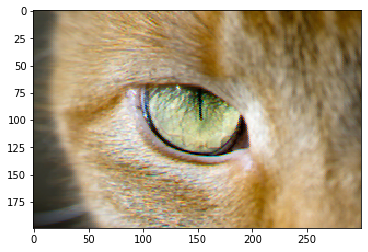

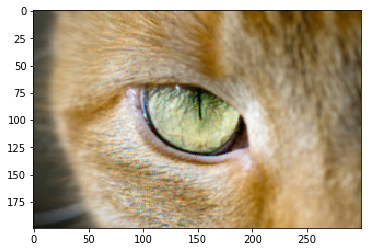

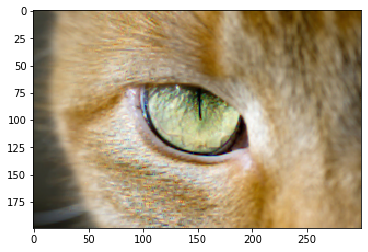

In [7]:
'''These lists will contain the output images of each of the demosaicing methods.'''
nn_output = []
interpolation_output = []
gradient_output = []

def demosaic_image(image, method='NN'):
    if method == 'NN':
        return demosaic_nn(image)
    elif method == 'interpolate':
        return demosaic_interpolate(image)
    elif method == 'gradient':
        return demosaic_gradient(image)
    else:
        raise ValueError('Unknown method')

def generate_output(mosaiced_images):
    
    # Demosaicing using the nearest neighbour method
    for image in mosaiced_images:
        op = demosaic_image(image, method='NN')
        nn_output.append(op)
        
    # Demosaicing using the linear interpolation method
    for image in mosaiced_images:
        op = demosaic_image(image, method='interpolate')
        interpolation_output.append(op)
        
    # Demosaicing using the gradient-based method
    for image in mosaiced_images:
        op = demosaic_image(image, method='gradient')
        gradient_output.append(op)
        
generate_output(mosaiced_images)

'''Modify the index of the image to show as an example here.'''
image_to_show = 2

plt.figure()
show_image(nn_output[image_to_show])
plt.figure()
show_image(interpolation_output[image_to_show])
plt.figure()
show_image(gradient_output[image_to_show])

## Evaluation



We will evaluate the algorithm by comparing your output to the ground truth color image. The input to your algorithm was constructed by artificially mosaicing it. This is not ideal in practice, but we will ignore this for now. We can compute the mean error between each color image and your output and report these numbers for each algorithm.

*Please note that just whether or not the mean errors lie below the threshold does not fully determine your grade; rather, they serve as an indication for you to check whether your algorithms perform correctly and to see which methods work better than others.*

In [8]:
def calculate_mean_difference(output_images):
    sum = 0.0
    for idx, image in enumerate(output_images):
        pixel_error = np.absolute(image - gtruth_images[idx])
        sum += np.mean(pixel_error)
    sum /= len(output_images)
    
    return sum
    
def evaluate(threshold):
    error = calculate_mean_difference(nn_output)
    if  error < threshold:
        print("NN -> Likely passed! Mean error is", error)
    else:
        print("NN -> Failed! Mean error is", error)
       
    error = calculate_mean_difference(interpolation_output)
    if  error < threshold:
        print("Interpolation -> Likely passed! Mean error is", error)
    else:
        print("Interpolation -> Failed! Mean error is", error)
    
    error = calculate_mean_difference(gradient_output)
    if  error < threshold:
        print("Gradient -> Likely passed! Mean error is", error)
    else:
        print("Gradient -> Failed! Mean error is", error)

evaluate(threshold=0.03)

NN -> Likely passed! Mean error is 0.02642341450232794
Interpolation -> Likely passed! Mean error is 0.0157644174550348
Gradient -> Likely passed! Mean error is 0.015079439999227473
